In [291]:
import cvxpy as cp
import numpy as np

print("MPC")

# System parameters
delta_t = 1  # Time step (seconds)
N = 20  # Prediction horizon

# State and input constraints
v_max = 15.28  # m/s (55 km/h)
a_min = -1.5  # m/s^2
a_max = 1.5  # m/s^2

# Cost function weights
lambda_u = 0.1
lambda_j = 0.01

# Speed profile
def get_v_ref(s):
    if s < 100:
        return 15.28
    
    if s < 180:
        return 8.33
    
    if s < 181:
        return 0.
    
    return 0.
    
def get_v_ref_vec(ts, s0):
    vs = []
    s = s0
    for t in ts:
        v = get_v_ref(s)
        vs.append(v)
        s += v * delta_t
        
    return vs

def get_v_ref_vec_s(ss):
    vs = []
    for s in ss:
        vs.append(get_v_ref(s))

    return vs

# Sim state
s_sim = 0
v_sim = 0
a_sim = 0

s_traj = []
v_traj = []
a_traj = []

T = 40

# Run
for ts in range(T):
    s_traj.append(s_sim)
    v_traj.append(v_sim)
    a_traj.append(a_sim)
    
    # Initial state
    s_init = s_sim  # Initial position in meters
    v_init = v_sim  # Initial velocity in m/s
    a_init = a_sim  # Initial acceleration in m/s^2

    # Define optimization variables
    s = cp.Variable(N+1)
    v = cp.Variable(N+1)
    a = cp.Variable(N)

    # Define the optimization problem
    cost = 0
    constraints = []

    # Set initial state constraints
    constraints += [s[0] == s_init, v[0] == v_init]

    # Set initial acceleration constraint
    constraints += [a[0] == a_init]

    # Add constraints and cost function components for each step in the horizon
    v_ref = get_v_ref_vec(range(N), s_init)
    print(v_ref)
    for k in range(N):
        # Define the cost function
        lambda_v = 1.0
        if k > 0 and v_ref[k] < v_ref[k-1]:
            # lambda_v *= 1000.0
            constraints += [cp.abs(v[k] - v_ref[k]) <= 0.5]
        cost += lambda_v * cp.square(v[k] - v_ref[k])
        
        # cost += lambda_u * cp.square(a[k])
        
        # Penalize changes in acceleration (jerk), except for the last step
        if k < N - 1:
            cost += lambda_j * cp.square(a[k+1] - a[k])
            
        # Define the system dynamics constraint
        constraints += [s[k+1] == s[k] + v[k] * delta_t]
        constraints += [v[k+1] == v[k] + a[k] * delta_t]
        
        # State constraints
        constraints += [0 <= v[k], v[k] <= v_ref[k]]
        
        # Input constraints
        constraints += [a_min <= a[k], a[k] <= a_max]

    # # Terminal cost
    # t_N = N * delta_t
    # v_des_N = np.interp(t_N, t_ref, v_ref)
    # constraints += [0 <= v[N], v[N] <= v_des_N]

    # Define the optimization problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve()

    # Extract the optimal trajectory
    s_opt = s.value
    v_opt = v.value
    a_opt = a.value

    # Display the results
    print("Optimal position trajectory: s =", s_opt)
    print("Optimal velocity trajectory: v =", v_opt)
    print("Optimal acceleration trajectory: a =", a_opt)

    s_sim += v_sim * delta_t
    v_sim += a_sim * delta_t
    a_sim = a_opt[1]


MPC
[15.28, 15.28, 15.28, 15.28, 15.28, 15.28, 15.28, 8.33, 8.33, 8.33, 8.33, 8.33, 8.33, 8.33, 8.33, 8.33, 0.0, 0.0, 0.0, 0.0]
Optimal position trajectory: s = [-6.68410360e-14  1.10101401e-07  4.40516220e-07  1.50011139e+00
  4.50032390e+00  9.00062077e+00  1.50009780e+01  2.25013670e+01
  3.08220313e+01  3.91520319e+01  4.74820316e+01  5.58026908e+01
  6.33026013e+01  6.93025179e+01  7.38024463e+01  7.68023914e+01
  7.83023569e+01  7.83023451e+01  7.83023451e+01  7.83023453e+01
  7.83023451e+01]
Optimal velocity trajectory: v = [ 1.10101534e-07  3.30414888e-07  1.50011095e+00  3.00021251e+00
  4.50029687e+00  6.00035721e+00  7.50038898e+00  8.32066436e+00
  8.33000054e+00  8.32999974e+00  8.32065916e+00  7.49991049e+00
  5.99991666e+00  4.49992843e+00  2.99994508e+00  1.49996547e+00
 -1.17662440e-05  4.65043725e-09  1.09010049e-07 -1.17315923e-07
  5.98633201e-04]
Optimal acceleration trajectory: a = [ 1.10110314e-07  1.50011051e+00  1.50010145e+00  1.50008428e+00
  1.50006028e+00  

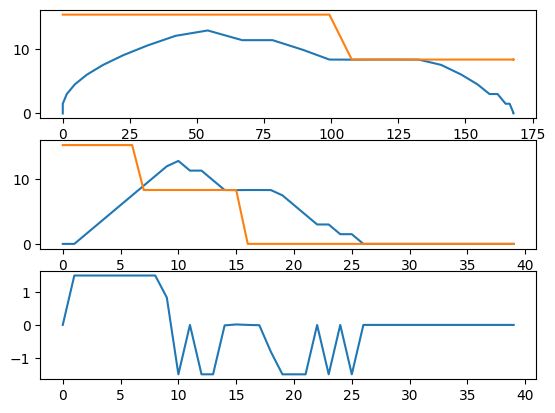

In [292]:
import matplotlib.pyplot as plt
%matplotlib inline

ts = np.linspace(0, T-1, T)
v_ref = get_v_ref_vec(ts, 0)

fig, axs = plt.subplots(3)

axs[0].plot(s_traj, v_traj)
axs[0].plot(s_traj, get_v_ref_vec_s(s_traj))

axs[1].plot(ts, v_traj)
axs[1].plot(ts, v_ref)

axs[2].plot(ts, a_traj)

plt.show()